<a href="https://colab.research.google.com/github/adapateja/OIBSIP/blob/main/FML_project_teju.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.3 MB/s eta 0:00:00


#**Importing neccesary libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from scipy import stats
import math

#**Showing the data**

reading the csv files

-->We have 3 datasets train,test and samplesubmission so lets use train.csv to examine the data 

In [3]:
train_data=pd.read_csv("/content/train.csv")
train_data.sample(2)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
3589,F27DE7F7F3AB,"In my opinion, The school shouldn't have to fo...",2.0,2.0,2.5,2.0,2.5,2.0
2028,98FDB2315471,Try different thing to grow.\n\nI agree about ...,1.5,2.0,2.0,2.0,2.0,1.5


Ok from the above data our final criteria is to find the score for a english text in the form of cohesion, syntax, vocabulary, phraseology, grammer and conventions..

By using text's in training data we have to find score for the text's in testing data and show them by their text id's in the submission file

#**Data Preprocessing and ED-Analysis**



In [4]:
#Knowing the shape
train_data.shape

(3911, 8)

In [5]:
#know the cloumn names
train_data.columns

Index(['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions'],
      dtype='object')

In [6]:
#Describing the data
train_data.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


From the above information we can say that there are 3911 different text's each one having there own id

And also maximum score in every property is 5 and average score is about 3.0-4.0 and minimum score is 1

In [7]:
#Checking the information of data in dataset
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


In [8]:
#checking number of null values in  each column
train_data.isnull().sum()

text_id        0
full_text      0
cohesion       0
syntax         0
vocabulary     0
phraseology    0
grammar        0
conventions    0
dtype: int64

From the above information we can say that there are no null values in our data so ther is no need to  handle with empty or null values

**Let's analysis the text for some sort of preprocessing by taking a sample text**

In [9]:
train_data['full_text'][0]

"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.\n\nmost students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go t

Here we can see in the text that there are some programming symbols like \n.

so let's remove them by replacing with empty spaces

In [10]:
#In the text that there are some programming symbols like \n. So we remove them by replacing with empty spaces

In [11]:
#Here we use re(Regular expression) to handle with \n, \t ans so on..
import re

train_data['full_text']=train_data["full_text"].replace(re.compile(r'[\n\r\t]'),' ',regex=True)
train=train_data.copy()

**Ok lets do cleaning to entire text in the data set**

In [12]:
text_train_data = train_data['full_text']

In [13]:
#Converting entire text to lower case
text_train_data = text_train_data.str.lower()

In [14]:
# removing special characters and numbers
text_train_data = text_train_data.apply(lambda x : re.sub("[^a-z]\s","",x) )

In [15]:
# remove hash tags
text_train_data = text_train_data.str.replace("#", "")

In [16]:
#remove words less than 3 character and greater than 7
text_train_data = text_train_data.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2 and len(w)<8]))

In [17]:
#Counting number of word in the entire text
count_words = text_train_data.str.findall(r'(\w+)').str.len()
print(count_words.sum())

1064587


In [18]:
#Remove frequently used words
most_freq_words = pd.Series(' '.join(text_train_data).lower().split()).value_counts()[:25]
text_train_data = text_train_data.apply(lambda x : " ".join(word for word in x.split() if word not in most_freq_words ))
print("Most frequently used words in the text\n",most_freq_words)

count_words = text_train_data.str.findall(r'(\w+)').str.len()
print("\nCounting number of word in the entire text after removing frequently used words:",count_words.sum())

Most frequently used words in the text
 the        52605
and        39550
you        34777
that       28085
they       23406
have       20274
can        18335
for        16994
are        14465
not        13779
because    13357
people     12681
with       11396
will       11039
your       10814
school     10204
their      10095
more        8942
what        8572
get         8204
good        8027
like        7202
time        7129
work        6859
want        6826
dtype: int64

Counting number of word in the entire text after removing frequently used words: 660970


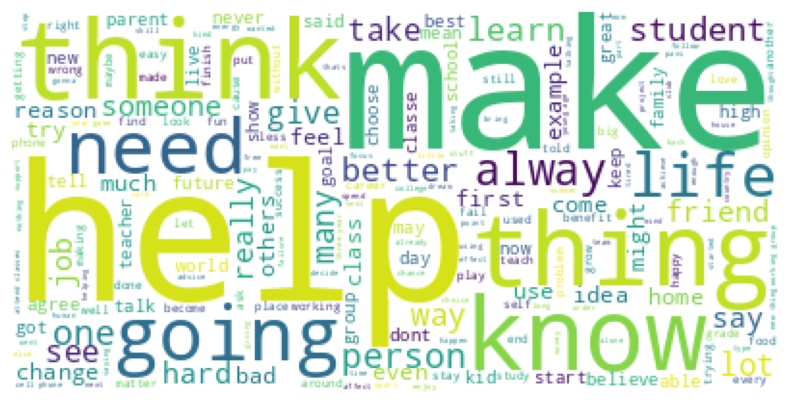

In [19]:
from wordcloud import WordCloud

corpus = ''.join(text_train_data)
wordcloud = WordCloud(background_color='white').generate(corpus)
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [20]:
apostrophe_dict = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [21]:
#now lets replace the apostrophe words in the text as normal words

def lookup_dict(txt, dictionary):
    for word in txt.split():
        if word.lower() in dictionary:
            if word.lower() in txt.split():
                txt = txt.replace(word, dictionary[word.lower()])
    return txt

text_train_data = text_train_data.apply(lambda x: lookup_dict(x,apostrophe_dict))

In [22]:
#Remove rare words in the text

from collections import Counter
from itertools import chain

# split words into lists
v = text_train_data.str.split().tolist() 
# compute global word frequency
c = Counter(chain.from_iterable(v))
# filter, join, and re-assign
text_train_data = [' '.join([j for j in i if c[j] > 1]) for i in v]
text_train_data = pd.Series(text_train_data)

total_word = 0
for x,word in enumerate(text_train_data):
    num_word = len(word.split())
    #print(num_word)
    total_word = total_word + num_word
print("Total number of words in the text after all cleaning is done:",total_word)

Total number of words in the text after all cleaning is done: 654869


In [23]:
text_train_data[0]

'think would benefit from wont change early morning shower there only classes helps them there house they shall / they will pay home hardest part getting wake brush teeth closet look think picked outfit look mirror youll either look see you shall / you will online classes wear stay home wont need stress about wear most usually take before either take before sleep when wake upsome both smell causes them miss bus effects there lesson cause come late online classes wont need miss lessons cause set take shower when out ready when home pay gives then smarter even pass there class schools even teacher dont know how teach then way itthat causes fail may repeat class'

**Ok now lets see some visualized data of our dataset**

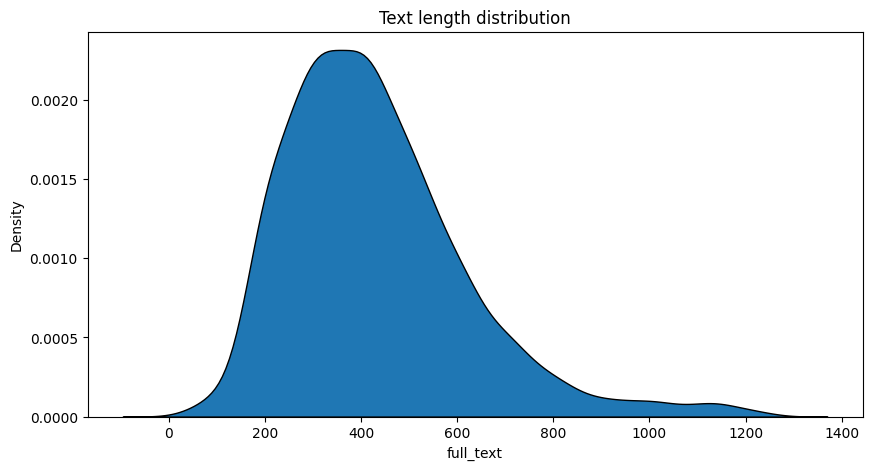

In [24]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot()
sns.kdeplot(x=train['full_text'].apply(lambda x:len(x.split())),data=train,ec="#000",fill=True,alpha=1,ax=ax,zorder=2)
ax.set_title("Text length distribution")
fig.show()

Here we are calculating the text length for each entry in the 'full_text' column of out dataset

And Generated a kernel density plot (kdeplot) of the text length distribution

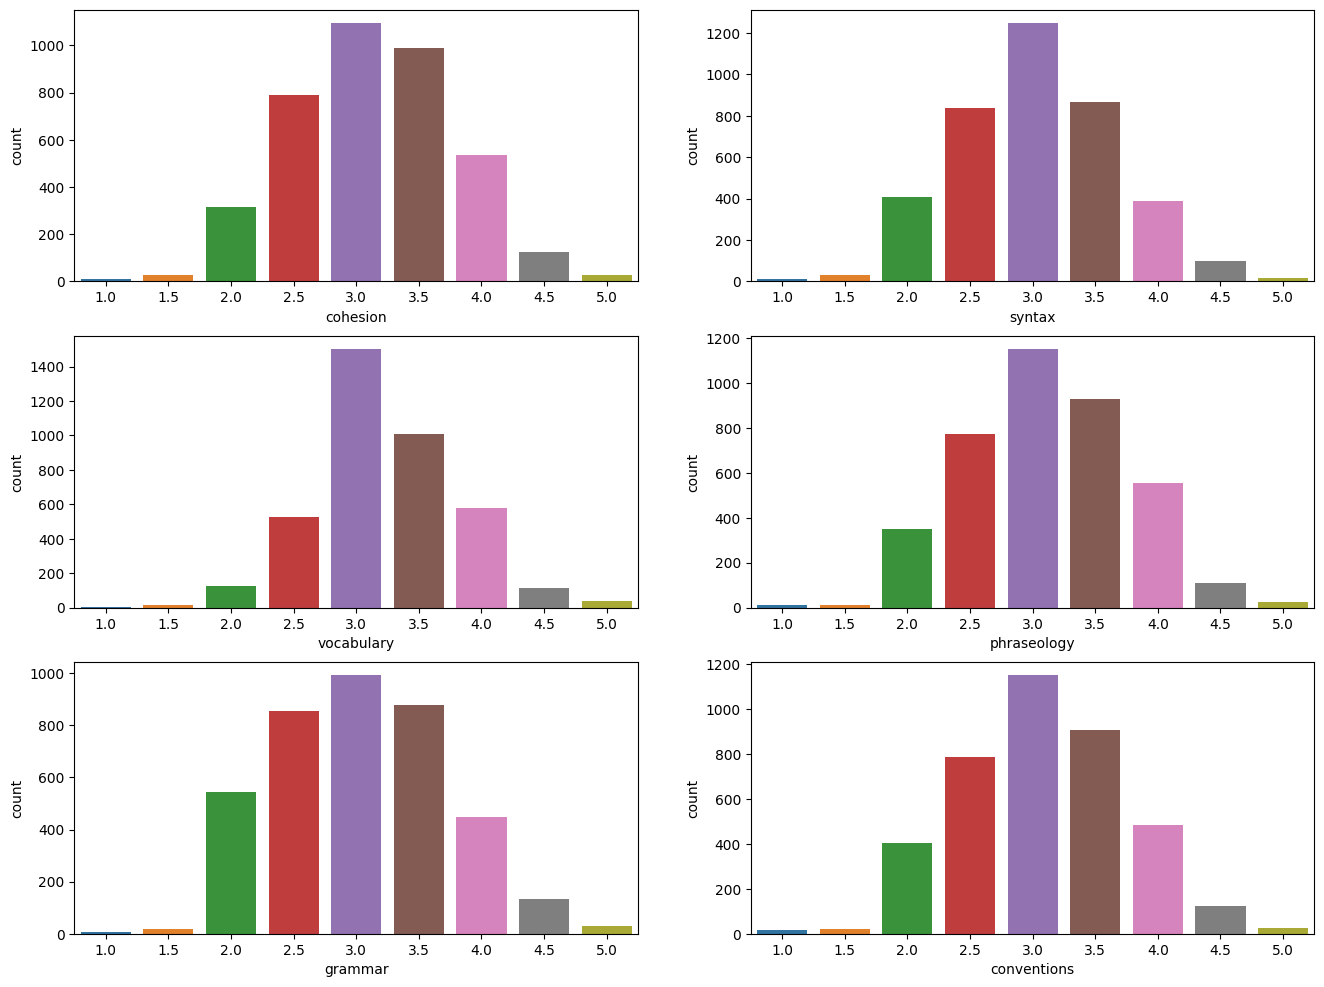

In [25]:
fig, axs = plt.subplots(3, 2, figsize=(16, 12))

sns.countplot(x="cohesion", data=train, linewidth=1.25, alpha=1, ax=axs[0][0], zorder=2)
sns.countplot(x="syntax", data=train, linewidth=1.25, alpha=1, ax=axs[0][1], zorder=2)
sns.countplot(x="vocabulary", data=train, linewidth=1.25, alpha=1, ax=axs[1][0], zorder=2)
sns.countplot(x="phraseology", data=train, linewidth=1.25, alpha=1, ax=axs[1][1], zorder=2)
sns.countplot(x="grammar", data=train, linewidth=1.25, alpha=1, ax=axs[2][0], zorder=2)
sns.countplot(x="conventions", data=train, linewidth=1.25, alpha=1, ax=axs[2][1], zorder=2)

fig.show()

Here we have ploted count plots for the variables in our dataset

cohesion,
 syntax,
 vocabulary,
 phraseology,
 grammar,
 conventions.

In [26]:
#Lets se the word count of the text's in our dataset
train['word_count'] = train.full_text.apply(lambda x: len(x.split()))
train.word_count.head()

0    261
1    533
2    320
3    728
4    234
Name: word_count, dtype: int64

Ok now lets visualize word count in the text's of our dataset by drawing a count plot

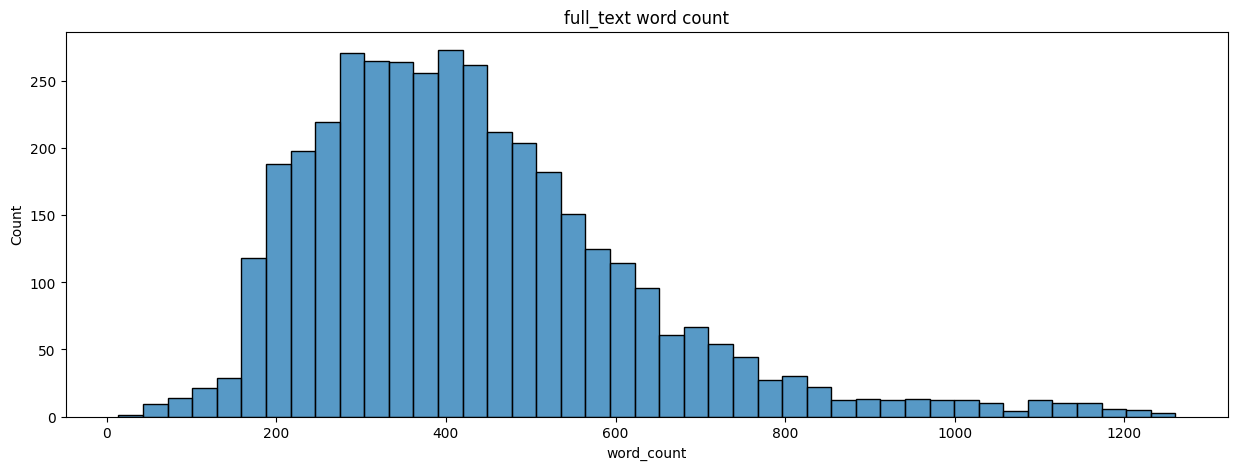

In [27]:
fig = plt.figure(figsize=(15, 5))
sns.histplot(data=train, x="word_count")
plt.title("full_text word count")
plt.show()

**Before preparing the training and tesing data we have to clean the testing data also**

In [28]:
# test_data=pd.read_csv("/content/test.csv")
# test_data['full_text']=test_data["full_text"].replace(re.compile(r'[\n\r\t]'),' ',regex=True)
# text_test_data = test_data['full_text']
# text_test_data = text_test_data.str.lower()
# text_test_data = text_test_data.apply(lambda x : re.sub("[^a-z]\s","",x))
# text_test_data = text_test_data.str.replace("#", "")
# text_test_data = text_test_data.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2 and len(w)<8]))
# most_freq_words = pd.Series(' '.join(text_test_data).lower().split()).value_counts()[:25]
# text_test_data = text_test_data.apply(lambda x : " ".join(word for word in x.split() if word not in most_freq_words ))
# text_test_data = text_test_data.apply(lambda x: lookup_dict(x,apostrophe_dict))
# v_test = text_test_data.str.split().tolist() 
# c_test = Counter(chain.from_iterable(v_test))
# text_test_data = [' '.join([j for j in i if c_test[j] > 1]) for i in v_test]
# text_test_data = pd.Series(text_test_data)

#**Preparing training and testing data**

In [29]:
variables = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar',  'conventions']
target_variables = train_data[variables]
target_variables

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,3.5,3.5,3.0,3.0,4.0,3.0
1,2.5,2.5,3.0,2.0,2.0,2.5
2,3.0,3.5,3.0,3.0,3.0,2.5
3,4.5,4.5,4.5,4.5,4.0,5.0
4,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...
3906,2.5,3.0,3.0,3.5,2.5,2.5
3907,4.0,4.0,4.0,4.0,3.5,3.0
3908,2.5,3.0,3.0,3.0,3.5,3.0
3909,4.0,4.5,4.5,4.0,4.5,4.5


In [30]:
y_train=target_variables
X_train = text_train_data.copy()
# X_test = text_test_data.copy()
X_train.shape,  y_train.shape

((3911,), (3911, 6))

In [31]:
y_train

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,3.5,3.5,3.0,3.0,4.0,3.0
1,2.5,2.5,3.0,2.0,2.0,2.5
2,3.0,3.5,3.0,3.0,3.0,2.5
3,4.5,4.5,4.5,4.5,4.0,5.0
4,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...
3906,2.5,3.0,3.0,3.5,2.5,2.5
3907,4.0,4.0,4.0,4.0,3.5,3.0
3908,2.5,3.0,3.0,3.0,3.5,3.0
3909,4.0,4.5,4.5,4.0,4.5,4.5


#**Modelling**

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Import the TfidfVectorizer class from sklearn.feature_extraction.text

vectorizer_tfidf = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=0.01)

# Create an instance of TfidfVectorizer with specified parameters:
# - stop_words='english' removes common English words
# - max_df=0.5 ignores terms that appear in more than 50% of the documents
# - min_df=0.01 ignores terms that appear in less than 1% of the documents

X_train = list(map(''.join, X_train))

# Assuming X_train is a list of lists, this line joins the inner lists into strings

# X_test = np.array(X_test).tolist()
# X_test = list(map(''.join, X_test))

# Assuming X_test is a numpy array, these lines convert it to a list of strings

X_train_vector = vectorizer_tfidf.fit_transform(X_train)

# Convert the text data in X_train to TF-IDF vectors using fit_transform()
# This step both fits the vectorizer on the training data and transforms it into TF-IDF vectors

# X_test_vector = vectorizer_tfidf.transform(X_test)

# Convert the text data in X_test to TF-IDF vectors using transform()
# This step transforms the test data into TF-IDF vectors using the fitted vectorizer


In [33]:
X_train_vector.shape, y_train.shape

((3911, 892), (3911, 6))

**SVR_MultiOutput_Model**

**-----Multi-Output regressor with SVR as estimator**

In [34]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Assuming you have X_train_vector as input features and y as true output labels

# Create the multi-output regressor model with SVR as the base estimator
model = MultiOutputRegressor(SVR())

# Fit the model to the data
model.fit(X_train_vector, y_train)

# Calculate the accuracy using the score method
accuracy = model.score(X_train_vector, y_train)

# Print the accuracy
print("Accuracy: {:.2f}".format((accuracy)*100))


predictions = model.predict(X_train_vector)
mse = mean_squared_error(y_train, predictions)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_train, predictions)
r_sqrd=r2_score(y_train, predictions)
print("Mean Squared Error: {:.2f}".format(mse))
print("Root Mean Square Error: {:.2f}".format(rmse))
print("Mean Absolute Error: {:.2f}".format(mae))
print("R^2: {:.2f}".format(r_sqrd))


Accuracy: 86.51
Mean Squared Error: 0.06
Root Mean Square Error: 0.24
Mean Absolute Error: 0.16
R^2: 0.87


### **LinearRegression**

In [35]:
from sklearn.linear_model import LinearRegression


model1 = MultiOutputRegressor(LinearRegression())
model1.fit(X_train_vector,y_train)

accuracy = model1.score(X_train_vector, y_train)

# Print the accuracy
print("Accuracy: {:.2f}".format((accuracy)*100))


predictions = model1.predict(X_train_vector)
mse = mean_squared_error(y_train, predictions)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_train, predictions)
r_sqrd=r2_score(y_train, predictions)

print("Mean Squared Error: {:.2f}".format(mse))
print("Root Mean Square Error: {:.2f}".format(rmse))
print("Mean Absolute Error: {:.2f}".format(mae))
print("R^2: {:.2f}".format(r_sqrd))

Accuracy: 45.73
Mean Squared Error: 0.23
Root Mean Square Error: 0.48
Mean Absolute Error: 0.38
R^2: 0.46


**RandomForest_MultiOutput_Model**

**-----Multi-output regressor with Random Forest as estimator**

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

base_estimator = RandomForestRegressor(n_estimators=100)

model = MultiOutputRegressor(base_estimator)

model.fit(X_train_vector, y_train)

accuracy = model.score(X_train_vector, y_train)

print("Accuracy: {:.2f}".format(accuracy * 100))

predictions = model.predict(X_train_vector)
mse = mean_squared_error(y_train, predictions)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_train, predictions)
r_sqrd=r2_score(y_train, predictions)
print("Mean Squared Error: {:.2f}".format(mse))
print("Root Mean Square Error: {:.2f}".format(rmse))
print("Mean Absolute Error: {:.2f}".format(mae))
print("R^2: {:.2f}".format(r_sqrd))

Accuracy: 88.76
Mean Squared Error: 0.05
Root Mean Square Error: 0.22
Mean Absolute Error: 0.17
R^2: 0.89


In [37]:
import xgboost as xgb
params_xgb = {'n_estimators': 1000, 'random_state':0}
model = xgb.XGBRegressor(
        **params_xgb,
        objective='reg:squarederror')
model.fit(X_train_vector,y_train)

accuracy = model.score(X_train_vector, y_train)

print("Accuracy: {:.2f}".format(accuracy * 100))

predictions = model.predict(X_train_vector)
mse = mean_squared_error(y_train, predictions)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_train, predictions)
r_sqrd=r2_score(y_train, predictions)

print("Mean Squared Error: {:.2f}".format(mse))
print("Root Mean Square Error: {:.2f}".format(rmse))
print("Mean Absolute Error: {:.2f}".format(mae))
print("R^2: {:.2f}".format(r_sqrd))

Accuracy: 99.99
Mean Squared Error: 0.00
Root Mean Square Error: 0.01
Mean Absolute Error: 0.01
R^2: 1.00


### **XGBRegressor**

In [38]:
import xgboost as xgb
params_xgb_cv =  {'subsample': 0.8, 'reg_alpha': 0, 'n_estimators': 740, 'min_child_weight': 12, 'max_depth': 6, 'lambda': 5, 'gamma': 0.3, 'eval_metric': 'rmse', 'eta': 0.03, 'colsample_bytree': 0.85, 'booster': 'gbtree'}
model = xgb.XGBRegressor(
        **params_xgb_cv,
        objective='reg:squarederror')
model.fit(X_train_vector, y_train)
accuracy = model.score(X_train_vector, y_train)

print("Accuracy: {:.2f}".format(accuracy * 100))

predictions = model.predict(X_train_vector)
mse = mean_squared_error(y_train, predictions)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_train, predictions)
r_sqrd=r2_score(y_train, predictions)

print("Mean Squared Error: {:.2f}".format(mse))
print("Root Mean Square Error: {:.2f}".format(rmse))
print("Mean Absolute Error: {:.2f}".format(mae))
print("R^2: {:.2f}".format(r_sqrd))

Accuracy: 74.49
Mean Squared Error: 0.11
Root Mean Square Error: 0.33
Mean Absolute Error: 0.26
R^2: 0.74


In [39]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor

base_estimator = DecisionTreeRegressor()
model = MultiOutputRegressor(base_estimator)
model.fit(X_train_vector, y_train)
accuracy = model.score(X_train_vector, y_train)

print("Accuracy: {:.2f}".format(accuracy * 100))

predictions = model.predict(X_train_vector)
mse = mean_squared_error(y_train, predictions)
print("Mean Squared Error: {:.2f}".format(mse))


Accuracy: 100.00
Mean Squared Error: 0.00


### **DecisionTreeREgressor**

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor

# Create a decision tree regressor with regularization parameters
base_estimator = DecisionTreeRegressor(max_depth=50, min_samples_split=25)

# Create a multi-output regressor with the decision tree as the base estimator
model = MultiOutputRegressor(base_estimator)

# Fit the model to the training data
model.fit(X_train_vector, y_train)
accuracy = model.score(X_train_vector, y_train)

print("Accuracy: {:.2f}".format(accuracy * 100))

# Make predictions on the training data
predictions = model.predict(X_train_vector)

mse = mean_squared_error(y_train, predictions)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_train, predictions)
r_sqrd=r2_score(y_train, predictions)
print("Mean Squared Error: {:.2f}".format(mse))
print("Root Mean Square Error: {:.2f}".format(rmse))
print("Mean Absolute Error: {:.2f}".format(mae))
print("R^2: {:.2f}".format(r_sqrd))

Accuracy: 74.55
Mean Squared Error: 0.11
Root Mean Square Error: 0.33
Mean Absolute Error: 0.24
R^2: 0.75


### **CatBoostREgressor**

In [41]:
from catboost import CatBoostRegressor

params = {'learning_rate': 0.3, 
          'depth': 12, 
          'l2_leaf_reg': 4, 
          'loss_function': 'MultiRMSE', 
          'eval_metric': 'MultiRMSE', 
          'task_type': 'CPU', 
          'iterations': 20,
          'od_type': 'Iter', 
          'boosting_type': 'Plain', 
          'bootstrap_type': 'Bayesian', 
          'allow_const_label': True, 
          'random_state': 1
         }
model = CatBoostRegressor(**params)
model.fit(X_train_vector, y_train)
accuracy = model.score(X_train_vector, y_train)

print("Accuracy: {:.2f}".format(accuracy * 100))

# Make predictions on the training data
predictions = model.predict(X_train_vector)

mse = mean_squared_error(y_train, predictions)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_train, predictions)
r_sqrd=r2_score(y_train, predictions)
print("Mean Squared Error: {:.2f}".format(mse))
print("Root Mean Square Error: {:.2f}".format(rmse))
print("Mean Absolute Error: {:.2f}".format(mae))
print("R^2: {:.2f}".format(r_sqrd))

0:	learn: 1.5612579	total: 44.4s	remaining: 14m 2s
1:	learn: 1.5238784	total: 1m 27s	remaining: 13m 3s
2:	learn: 1.4940442	total: 2m 10s	remaining: 12m 21s
3:	learn: 1.4643256	total: 2m 53s	remaining: 11m 35s
4:	learn: 1.4368263	total: 3m 39s	remaining: 10m 57s
5:	learn: 1.4194277	total: 4m 22s	remaining: 10m 11s
6:	learn: 1.4065643	total: 5m 6s	remaining: 9m 28s
7:	learn: 1.3913110	total: 5m 49s	remaining: 8m 43s
8:	learn: 1.3706210	total: 6m 33s	remaining: 8m
9:	learn: 1.3587774	total: 7m 16s	remaining: 7m 16s
10:	learn: 1.3436716	total: 8m	remaining: 6m 32s
11:	learn: 1.3303662	total: 8m 43s	remaining: 5m 49s
12:	learn: 1.3114748	total: 9m 27s	remaining: 5m 5s
13:	learn: 1.3008525	total: 10m 12s	remaining: 4m 22s
14:	learn: 1.2875687	total: 10m 56s	remaining: 3m 38s
15:	learn: 1.2780369	total: 11m 40s	remaining: 2m 55s
16:	learn: 1.2695141	total: 12m 23s	remaining: 2m 11s
17:	learn: 1.2601675	total: 13m 8s	remaining: 1m 27s
18:	learn: 1.2522276	total: 13m 52s	remaining: 43.8s
19:	le

In [42]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
params_lgb = {
    "n_estimators": 1000,
    "verbose": -1
}
model = MultiOutputRegressor(LGBMRegressor(**params_lgb))
model.fit(X_train_vector, y_train)
accuracy = model.score(X_train_vector, y_train)

print("Accuracy: {:.2f}".format(accuracy * 100))

# Make predictions on the training data
predictions = model.predict(X_train_vector)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_train, predictions)
print("Mean Squared Error: {:.2f}".format(mse))

Accuracy: 99.82
Mean Squared Error: 0.00


### **Ridge Regression**

In [43]:
from sklearn.linear_model import Ridge

model = MultiOutputRegressor(Ridge(copy_X=False))
model.fit(X_train_vector, y_train)
accuracy = model.score(X_train_vector, y_train)

print("Accuracy: {:.2f}".format(accuracy * 100))

# Make predictions on the training data
predictions = model.predict(X_train_vector)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_train, predictions)
print("Mean Squared Error: {:.2f}".format(mse))

Accuracy: 42.37
Mean Squared Error: 0.25


**LSTM Regressor Model**

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.multioutput import MultiOutputRegressor
from keras.models import Model
from keras.layers import LSTM, Dense, Dropout, Input, Reshape
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Define the variables and target_variables as before
variables = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
target_variables = train_data[variables]

y_train = target_variables
X_train = text_train_data.copy()
X_train.shape, y_train.shape

# Preprocess the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
vocab_size = len(tokenizer.word_index) + 1

max_length = max([len(seq) for seq in sequences])
X_train_padded = pad_sequences(sequences, maxlen=max_length)

# Reshape the input data to have three dimensions
X_train_padded = X_train_padded.reshape(X_train_padded.shape[0], X_train_padded.shape[1], 1)

# Define the input layer
inputs = Input(shape=(max_length, 1))
# Add LSTM layer
lstm = LSTM(64)(inputs)
# Reshape the output of LSTM layer
reshaped = Reshape((64,))(lstm)
# Add Dropout layer for regularization
dropout = Dropout(0.2)(reshaped)
# Add Dense layer with linear activation for each output variable
outputs = [Dense(1, activation='linear')(dropout) for _ in variables]

# Create the model with inputs and outputs
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with mean squared error loss and adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model to the data
model.fit(X_train_padded, [y_train[variable] for variable in variables])

# Evaluate the model on the training data
mse_losses = model.evaluate(X_train_padded, [y_train[variable] for variable in variables])

# Calculate the accuracy
accuracy = 1 - np.mean(mse_losses)

# Print the accuracy
print("Accuracy: {:.2f}".format(accuracy * 100))


123/123 [==============================] - 2s 10ms/step - loss: 2.6117 - dense_loss: 0.4447 - dense_1_loss: 0.4202 - dense_2_loss: 0.3448 - dense_3_loss: 0.4329 - dense_4_loss: 0.5064 - dense_5_loss: 0.4626
Accuracy: 25.38


**Multi-output LSTM Neural Network model**

In [45]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the variables and target_variables as before
variables = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
target_variables = train_data[variables]

y_train = target_variables
X_train = text_train_data.copy()
X_train.shape, y_train.shape

# Preprocess the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
vocab_size = len(tokenizer.word_index) + 1

max_length = max([len(seq) for seq in sequences])
X_train_padded = pad_sequences(sequences, maxlen=max_length)

# Create the neural network model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(variables), activation='linear'))

# Compile the model with mean squared error loss and adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model to the data
model.fit(X_train_padded, y_train, epochs=20, batch_size=32)

# Evaluate the model on the training data
y_train_pred = model.predict(X_train_padded)
mse_loss = mean_squared_error(y_train, y_train_pred)

# Calculate the accuracy (1 - MSE)
accuracy = 1 - mse_loss

# Print the accuracy
print("Accuracy: {:.2f}".format(accuracy * 100))

predictions = model.predict(X_train_vector)
mse = mean_squared_error(y_train, predictions)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_train, predictions)
r_sqrd=r2_score(y_train, predictions)
print("Mean Squared Error: {:.2f}".format(mse))
print("Root Mean Square Error: {:.2f}".format(rmse))
print("Mean Absolute Error: {:.2f}".format(mae))
print("R^2: {:.2f}".format(r_sqrd))


Epoch 1/20
123/123 [==============================] - 32s 226ms/step - loss: 1.9275
Epoch 2/20
123/123 [==============================] - 18s 145ms/step - loss: 0.7415
Epoch 3/20
123/123 [==============================] - 12s 98ms/step - loss: 0.6421
Epoch 4/20
123/123 [==============================] - 10s 77ms/step - loss: 0.6107
Epoch 5/20
123/123 [==============================] - 8s 65ms/step - loss: 0.5504
Epoch 6/20
123/123 [==============================] - 9s 72ms/step - loss: 0.4738
Epoch 7/20
123/123 [==============================] - 6s 50ms/step - loss: 0.4182
Epoch 8/20
123/123 [==============================] - 7s 58ms/step - loss: 0.3826
Epoch 9/20
123/123 [==============================] - 7s 55ms/step - loss: 0.3364
Epoch 10/20
123/123 [==============================] - 5s 40ms/step - loss: 0.3232
Epoch 11/20
123/123 [==============================] - 6s 49ms/step - loss: 0.3127
Epoch 12/20
123/123 [==============================] - 6s 48ms/step - loss: 0.2943
Epoch 1

ValueError: ignored